In [ ]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 2.1MB 14.5MB/s 
     |████████████████████████████████| 1.2MB 55.6MB/s 
     |████████████████████████████████| 870kB 54.2MB/s 
     |████████████████████████████████| 3.3MB 53.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.4-cp37-none-any.whl size=114307 sha256=386f2612569184d34a3dd9968823eb598e1b4a764e91fa532c4f4e7071c8c4c3
  Stored in directory: /root/.cache/pip/wheels/26/ea/89/d0d2e013d951b6d23270aa9ca4018b82632ab7cd933c331316
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=f474cdf27fd8cd8b3d00a370dc8c92ff274dfcafa66e70ccd8865dc69da030ec
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sentence-transformers sacremoses


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path ='/content/drive/MyDrive/challenge/Eluvio_DS_Challenge.csv'
d = pd.read_csv(path)

In [ ]:
len(d)

509236

In [ ]:
d.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [ ]:
d.count() #count of all the non nan values

time_created    509236
date_created    509236
up_votes        509236
down_votes      509236
title           509236
over_18         509236
author          509236
category        509236
dtype: int64

In [ ]:
print("Total number of categories = "+str(len(pd.unique(d['category'])))) #different categories of article is 1, hence there is only 1 category for all the articles
print("Total number of authors = "+str(len(pd.unique(d['author'])))) #toal number of authors that have written the articles
print("total number of days recorded = "+str(len(pd.unique(d['date_created'])))) #total number of days recorded
print(len(pd.unique(d['down_votes']))) #different downvotes, since the unique value of it is 1, evey downvote is 0

Total number of categories = 1
Total number of authors = 85838
total number of days recorded = 3223
1


**Dsipalying the top 10 most popular authors according to the total number of votes obtained by all their areticles combined**

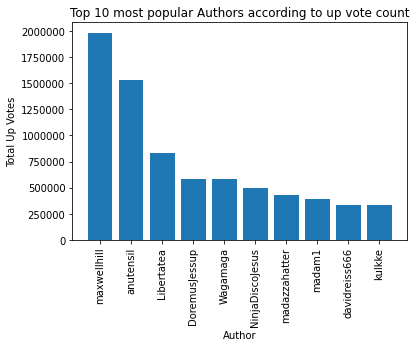

In [4]:
t = d.groupby('author')
x = t['up_votes'].agg(np.sum)
x = x.sort_values(ascending=False)
x = x[:10]
author_names, upVotes = x.index.tolist(), list(x.values)
plt.bar(author_names,upVotes)
plt.title('Top 10 most popular Authors according to up vote count')
plt.xlabel('Author')
plt.ylabel('Total Up Votes')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation='vertical')
plt.show()

**encoding the titles of the articles using the sentence embeddings from a BERT based model**

In [ ]:
title_list = list(d['title'])
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens', device='cuda')
bert_title_list = sbert_model.encode(title_list)

**Performing PCA to reduce the dimension of bert sentence embeddings from 768 to 5**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaling=StandardScaler()
scaling.fit(bert_title_list)
Scaled_data=scaling.transform(bert_title_list)

In [ ]:
principal=PCA(n_components=5)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)

**Storing the reduced title data in a pickle file**

In [7]:
path_store ='/content/drive/MyDrive/challenge/'
file_name = 'sentence_embeddings.pkl'

In [ ]:
import pickle
with open(path_store+file_name, 'wb') as file:
  pickle.dump(x, file)'''

In [8]:
import pickle
with open(path_store+file_name, 'rb') as file:
  tst = pickle.load(file)

tst

array([[-11.621831  ,  -2.5171435 ,  -6.9621315 ,  11.475348  ,
          3.851427  ],
       [ 14.269606  ,   0.12122028,  -0.93899155,   8.586804  ,
         -3.3515668 ],
       [  9.340078  ,  -1.4283856 ,  -4.893223  ,   9.5235    ,
         -2.6049767 ],
       ...,
       [ 13.838903  ,   0.90543795,  -5.5414047 ,   4.4716396 ,
          4.2750688 ],
       [  3.4042845 ,  -6.386664  ,  -5.693419  ,  -2.2083144 ,
         -1.2406759 ],
       [-11.859882  ,  -0.08033418,  -1.4309349 ,   6.4258537 ,
         -3.713122  ]], dtype=float32)

**Encoding the Author names by giving them an integer vallue**

In [9]:
ls = list(pd.unique(d['author']))
encoded_authors = {}
j = 0
for i in ls:
  encoded_authors[i] = j
  j+=1 

ks = list(d['author'])
encoded_author_list = []
for i in ks:
  encoded_author_list.append(encoded_authors[i])

**Creating the target Y vector**

Y vector indicates whether an article is popular or not in the form of binary classification of 1 or 0.
If the number of upvotes of an article are grater than the Q3 of the all the upvotes present in the distribution, then it is considered as popular and hence has the label 1 ele the unpopular and consecutively the label 0

In [5]:
q3 = np.quantile(d['up_votes'], 0.75)
y = [1 if i > q3 else 0 for i in d['up_votes']]
y = np.array(y)

**Creating the input X vector and splitting the data into train and test**

In [10]:
X_test = []
for i,j in zip(tst,encoded_author_list):
  X_test.append(np.append(i,j))
X = np.array(X_test)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest **Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.763     0.981     0.858     77127
           1      0.453     0.049     0.088     24721

    accuracy                          0.755    101848
   macro avg      0.608     0.515     0.473    101848
weighted avg      0.688     0.755     0.671    101848



**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=1.0, tol=0.01)

LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.01, verbose=0,
                   warm_start=False)

In [ ]:
y_predict = LR.predict(X_test)
print(metrics.classification_report(y_test, y_predict, digits=3))

              precision    recall  f1-score   support

           0      0.766     0.887     0.822     77127
           1      0.305     0.154     0.205     24721

    accuracy                          0.709    101848
   macro avg      0.535     0.521     0.513    101848
weighted avg      0.654     0.709     0.672    101848



**XGBoost Classifier**

In [13]:
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [16]:
y_predict = xgb.predict(X_test)
print(metrics.classification_report(y_test, y_predict, digits=3))

              precision    recall  f1-score   support

           0      0.760     0.998     0.863     77127
           1      0.716     0.018     0.034     24721

    accuracy                          0.760    101848
   macro avg      0.738     0.508     0.449    101848
weighted avg      0.749     0.760     0.662    101848



**Gradient Boosting Classifier**

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier()
gbdt.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [19]:
y_predict = gbdt.predict(X_test)
print(metrics.classification_report(y_test, y_predict, digits=3))

              precision    recall  f1-score   support

           0      0.760     0.997     0.863     77127
           1      0.703     0.019     0.037     24721

    accuracy                          0.760    101848
   macro avg      0.732     0.508     0.450    101848
weighted avg      0.746     0.760     0.662    101848

